# Разведочный анализ данных

### Загружаем необходимые библиотеки

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import matplotlib.ticker as ticker
%matplotlib inline

### Загружаем данные

In [3]:
production = pd.read_csv('production.csv', delimiter=';')

In [4]:
harpy_data = production.loc[production["supplier"] == "harpy.co"]
westeros_data = production.loc[production["supplier"] == "westeros.inc"].reset_index().drop(["index"], axis = 1)

### Вспомогательные функции

In [5]:
def get_part_data(data):
    defects_month = np.zeros(6) # Сломались после i + 1-го месяца эксплуатации
    prod_month = np.zeros(6) # Произведено в i + 1-ый месяц

    for i in range(data.shape[0]):
        if (data["report.date"][i] == data["production.date"][i]):
            prod_month[data["report.date"][i] - 1] += data["produced"][i]
        else:    
            defects_month[data["report.date"][i] - data["production.date"][i] - 1] += data["defects"][i]
        
    part_broke = np.zeros(6)
    for i in range(6):
        part_broke[i] = defects_month[i] / prod_month[:6 - i].sum()
        
    return defects_month, prod_month, part_broke

In [6]:
def get_anomaly(data):
    prod_month = np.zeros(6) # Произведено в i + 1-ый месяц
    defects_month = np.zeros(6) # Сломались после i + 1-го месяца произвства (на первый месяц эксплуатации)

    for i in range(data.shape[0]):
        if (data["report.date"][i] == data["production.date"][i]):
            prod_month[data["report.date"][i] - 1] += data["produced"][i]
        elif (data["report.date"][i] - data["production.date"][i] == 1):    
            defects_month[data["production.date"][i] - 1] += data["defects"][i]
        
    part_broke = defects_month / prod_month
        
    return defects_month, prod_month, part_broke

### Доля сломанных мечей поставщиков стали

In [7]:
a = get_part_data(westeros_data)[0].sum() / get_part_data(westeros_data)[1].sum()
b = get_part_data(harpy_data)[0].sum() / get_part_data(harpy_data)[1].sum()
print('Westeros.inc: ', "%.4f" %a)
print('Harpy.co: ', "%.4f" %b)

Westeros.inc:  0.2615
Harpy.co:  0.1928


### Количество произведенного и дефектного товара за 6 месяцев, относительная частота дефекта

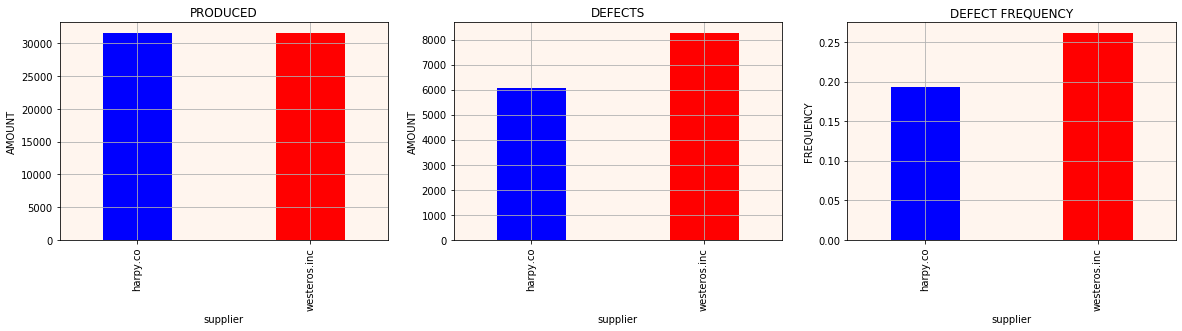

In [97]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,4))
ax1.set_title('PRODUCED')
ax1.set_ylabel('AMOUNT')
ax1.set_facecolor('seashell')
full_prod = production.groupby(['supplier'])['produced'].sum()
full_prod.plot.bar(ax = ax1, width = 0.4, grid = True, color =['blue','red'])


ax2.set_title('DEFECTS')
ax2.set_ylabel('AMOUNT')
ax2.set_facecolor('seashell')
full_defects = production.groupby(['supplier'])['defects'].sum()
full_defects.plot.bar(ax = ax2, width = 0.4, grid = True, color =['blue','red'])

ax3.set_title('DEFECT FREQUENCY')
ax3.set_ylabel('FREQUENCY')
ax3.set_facecolor('seashell')
defect_freguence = full_defects / full_prod
defect_freguence.plot.bar(ax = ax3, width = 0.4, grid = True, color =['blue','red'])

plt.show()

### Диаграмма доли сломанных мечей в i-ый месяц эксплуатации 

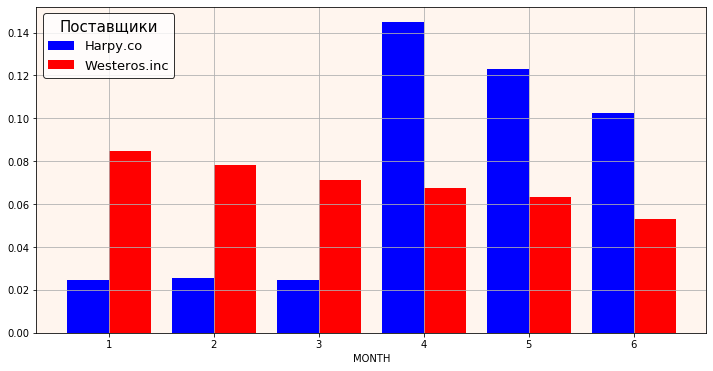

In [93]:
#  Задаем смещение равное половине ширины прямоугольника:
x1 = np.arange(1, 7) - 0.2
x2 = np.arange(1, 7) + 0.2
y1 = get_part_data(harpy_data)[2]
y2 = get_part_data(westeros_data)[2]

fig, ax = plt.subplots()

ax.set_facecolor('seashell')
ax.bar(x1, y1, width=0.4, color='blue', label='Harpy.co', align='center')
ax.bar(x2, y2, width=0.4, color='red', label='Westeros.inc', align='center')
ax.set_xlabel("MONTH")

fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

ax.grid(True)
ax.legend(fontsize = 13,
          ncol = 1,    #  количество столбцов
          facecolor = 'white',    #  цвет области
          edgecolor = 'black',    #  цвет крайней линии
          title = 'Поставщики',    #  заголовок
          title_fontsize = '15',    #  размер шрифта заголовка
          loc = 2
         )


plt.show()

### График доли сломанных мечей на i-ый месяц эксплуатации 

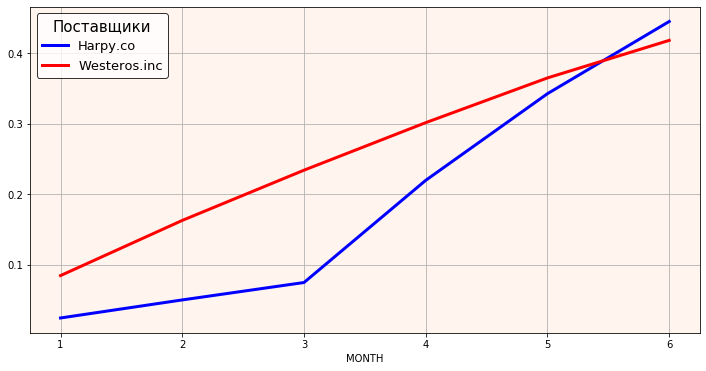

In [94]:
_, ax = plt.subplots(figsize = (12,6))

x = np.arange(1, 7)
y1 = get_part_data(harpy_data)[2]
y2 = get_part_data(westeros_data)[2]
for i in range(1, 6):
    y1[i] += y1[i - 1]
    y2[i] += y2[i - 1]
ax.set_facecolor('seashell')
ax.grid(True)
ax.plot(x, y1, lw=3, color='blue', alpha=1, label='Harpy.co')
ax.plot(x, y2, lw=3, color='red', alpha=1, label='Westeros.inc')
ax.set_xlabel('MONTH')
ax.legend(fontsize = 13,
          ncol = 1,    #  количество столбцов
          facecolor = 'white',    #  цвет области
          edgecolor = 'black',    #  цвет крайней линии
          title = 'Поставщики',    #  заголовок
          title_fontsize = '15'    #  размер шрифта заголовка
         )
plt.show()

### Доля сломанных мечей на следующий месяц после производства (для поиска аномалий)

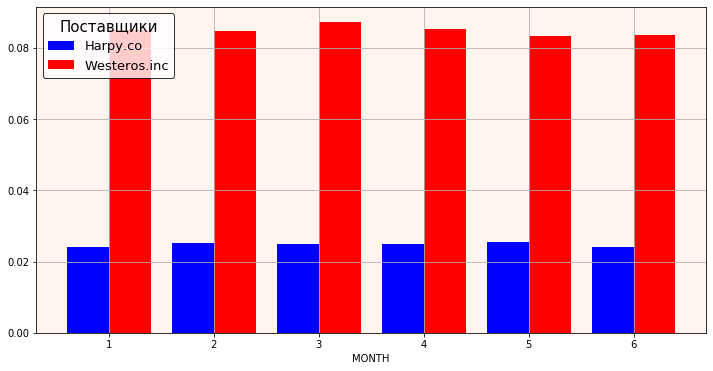

In [92]:
#  Задаем смещение равное половине ширины прямоугольника:
x1 = np.arange(1, 7) - 0.2
x2 = np.arange(1, 7) + 0.2
y1 = get_anomaly(harpy_data)[2]
y2 = get_anomaly(westeros_data)[2]

fig, ax = plt.subplots()
ax.set_facecolor('seashell')
ax.bar(x1, y1, width=0.4, color='blue', label='Harpy.co', align='center')
ax.bar(x2, y2, width=0.4, color='red', label='Westeros.inc', align='center')
ax.set_xlabel('MONTH')

fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

ax.grid(True)

ax.legend(fontsize = 13,
          ncol = 1,    #  количество столбцов
          facecolor = 'white',    #  цвет области
          edgecolor = 'black',    #  цвет крайней линии
          title = 'Поставщики',    #  заголовок
          title_fontsize = '15',   #  размер шрифта заголовка
          loc = 0
         )

plt.show()